## Import Required Libraries

In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_dir = 'drive/MyDrive/CDSS_DATA/Face Mask Dataset/Train'
test_dir = 'drive/MyDrive/CDSS_DATA/Face Mask Dataset/Test'
val_dir = 'drive/MyDrive/CDSS_DATA/Face Mask Dataset/Validation'

### Let's view some of the images of **Train** Dataset

In [ ]:
data_train = image_dataset_from_directory(train_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
data_validation = image_dataset_from_directory(val_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
data_test = image_dataset_from_directory(test_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)


Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


In [ ]:
classes_train = data_train.class_names
plt.figure(figsize=(10,10))
for img, label in data_train.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(classes_train[int(label[i])])
        plt.axis('off')


# from IPython.display import clear_output
clear_output()

## Data Augmentation

In [ ]:
# Image size
IMG_SIZE = (256, 256)

# data argumentation
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                       rotation_range=45,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=True
                                       )

# data argumentation
test_datagen = ImageDataGenerator(rescale= 1 / 255.0)

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=200,
                                         shuffle=True,
                                         class_mode="categorical")

test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE),
                                         color_mode="rgb",
                                         batch_size=64,
                                         shuffle=True,
                                         class_mode="categorical")

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.



## MODEL ARCHITECTURE for VGG-19

In [ ]:
from keras.applications.vgg19 import VGG19
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(256,256,3))

for layer in vgg19.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 2)                 65538     
                                                                 
Total params: 20089922 (76.64 MB)
Trainable params: 65538 (256.01 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


## Compile the Model

In [ ]:
# model compile
from keras.metrics import Precision, Recall, AUC
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

## Model Fitting

In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(train_dataset,
                              validation_data=test_dataset,
                              batch_size=32,
                              epochs=5,
                              verbose=1)

Epoch 1/5
50/50 [==============================] - 237s 5s/step - loss: 0.5847 - accuracy: 0.8064 - precision_2: 0.7804 - recall_2: 0.8420 - auc_2: 0.8703 - val_loss: 0.1126 - val_accuracy: 0.9597 - val_precision_2: 0.9407 - val_recall_2: 0.9748 - val_auc_2: 0.9918
Epoch 2/5
50/50 [==============================] - 219s 4s/step - loss: 0.1448 - accuracy: 0.9489 - precision_2: 0.9253 - recall_2: 0.9624 - auc_2: 0.9871 - val_loss: 0.0830 - val_accuracy: 0.9728 - val_precision_2: 0.9615 - val_recall_2: 0.9808 - val_auc_2: 0.9961
Epoch 3/5
50/50 [==============================] - 213s 4s/step - loss: 0.1164 - accuracy: 0.9616 - precision_2: 0.9411 - recall_2: 0.9751 - auc_2: 0.9921 - val_loss: 0.0733 - val_accuracy: 0.9738 - val_precision_2: 0.9635 - val_recall_2: 0.9849 - val_auc_2: 0.9970
Epoch 4/5
50/50 [==============================] - 217s 4s/step - loss: 0.0987 - accuracy: 0.9669 - precision_2: 0.9495 - recall_2: 0.9767 - auc_2: 0.9946 - val_loss: 0.0670 - val_accuracy: 0.9778 - val

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score
import numpy as np
model.evaluate(test_dataset)

predictions=model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true = test_dataset.classes
conf_matrix = confusion_matrix(y_true, y_pred)
print(accuracy_score(y_true,y_pred))
print("Confusion Matrix:")
print(conf_matrix)

16/16 [==============================] - 7s 439ms/step
0.5120967741935484
Confusion Matrix:
[[245 238]
 [246 263]]


In [ ]:
class_indices = validation_dataset.class_indices

# Get the list of classes (class labels)
class_labels = list(class_indices.keys())

# Get the true labels using the file paths from the generator
true_labels = []
for filename in validation_dataset.filenames:
    # Extract the class label from the filename
    label = filename.split('/')[0]  # Assuming the class label is the first part of the path
    true_labels.append(class_indices[label])

true_labels = np.array(true_labels)
print(true_labels)

In [ ]:
predictions = model.predict(test_dataset)

16/16 [==============================] - 10s 634ms/step


In [ ]:
print(predictions.shape)
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)
countT =0
countF=0
for predicted_label in predicted_labels:
    if predicted_label == 0:
        countF +=1
    else:
        countT +=1
print(countT,countF)

In [ ]:
real_true=0
real_false=0
for images, labels in data_validation:
    # Iterate through images in the batch
    for label in labels.numpy():
        if label == 0:
            real_false += 1
        else:
            real_true += 1
print(real_true,real_false)



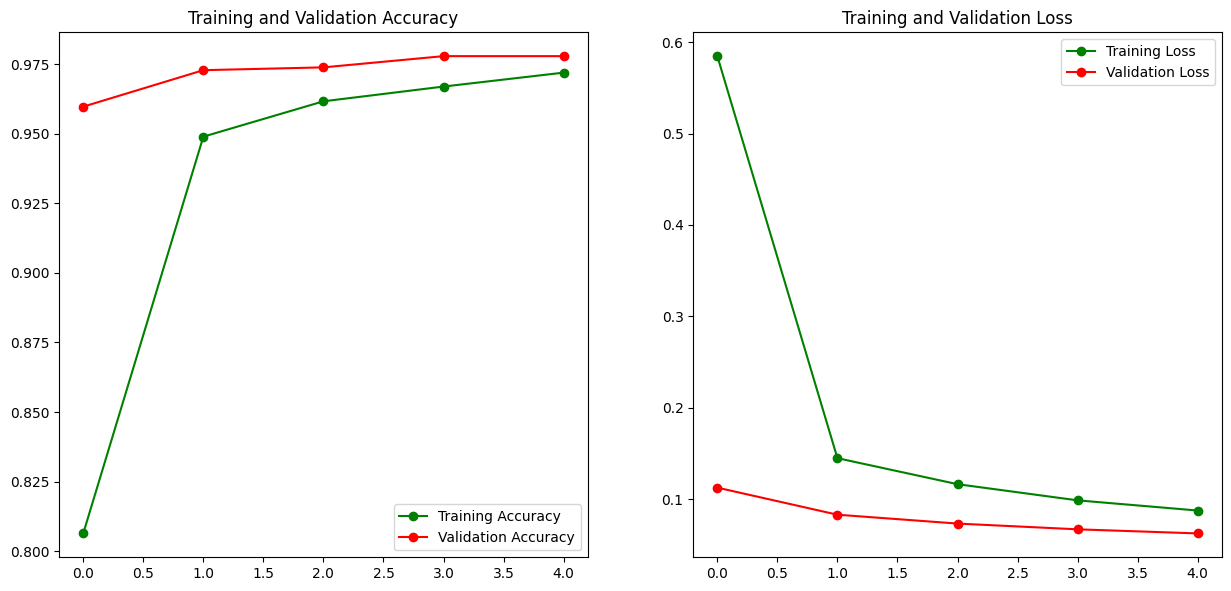

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc,"go-", label='Training Accuracy')
plt.plot(epochs_range, val_acc,"ro-", label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss,"go-", label='Training Loss')
plt.plot(epochs_range, val_loss,"ro-", label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Prediction

In [ ]:
test_pred = model.predict(test_dataset)

16/16 [==============================] - 7s 437ms/step


In [ ]:
output = [np.argmax(op) for op in test_pred]
df_output = pd.DataFrame(output)
print(df_output.value_counts())

1    501
0    491
dtype: int64


In [ ]:
def img_preprocessing(path):
    sample_mask_img = cv2.imread(path)
    sample_mask_img = cv2.resize(sample_mask_img,(256,256))
    plt.imshow(sample_mask_img)
    sample_mask_img = np.reshape(sample_mask_img,[1,256,256,3])
    sample_mask_img = sample_mask_img/255.0
    res = np.argmax(model.predict(sample_mask_img))
    print('            ', colored(classes_train[res], "red"))

In [2]:
import glob

folder_path = 'drive/MyDrive/CDSS_DATA/Face Mask Dataset/Test/WithoutMask'
image_extensions = ['*.png']

# Create a list of image file paths
image_files = []
for extension in image_extensions:
    image_files.extend(glob.glob(f'{folder_path}/{extension}'))
no_true = 0
# Loop over the image files
for image_file in image_files:
    sample_mask_img = cv2.imread(image_file)
    sample_mask_img = cv2.resize(sample_mask_img,(256,256))
    sample_mask_img = np.reshape(sample_mask_img,[1,256,256,3])
    sample_mask_img = sample_mask_img/255.0
    res = np.argmax(model.predict(sample_mask_img))
    if res == 1:
        no_true += 1
print("Predicted Correct",no_true)
print("Predicted Wrong", len(image_files)-no_true)
print("Actual Number", len(image_files))

Predicted Correct 0
Predicted Wrong 0
Actual Number 0


In [ ]:
import glob

folder_path = 'drive/MyDrive/CDSS_DATA/Face Mask Dataset/Test/WithMask'
image_extensions = ['*.png']

# Create a list of image file paths
image_files = []
for extension in image_extensions:
    image_files.extend(glob.glob(f'{folder_path}/{extension}'))
no_true = 0
# Loop over the image files
for image_file in image_files:
    sample_mask_img = cv2.imread(image_file)
    sample_mask_img = cv2.resize(sample_mask_img,(256,256))
    sample_mask_img = np.reshape(sample_mask_img,[1,256,256,3])
    sample_mask_img = sample_mask_img/255.0
    res = np.argmax(model.predict(sample_mask_img))
    if res == 0:
        no_true += 1
print(no_true)

In [ ]:
print(data_train.class_names)

1/1 [==============================] - 0s 20ms/step
             WithMask


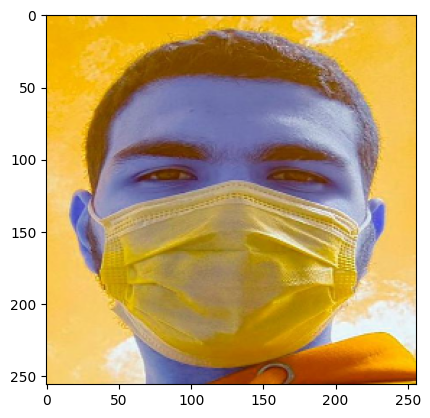

In [ ]:
img_preprocessing('drive/MyDrive/CDSS_DATA/Face Mask Dataset/Validation/WithMask/hesham1.png')

1/1 [==============================] - 0s 21ms/step
             WithMask


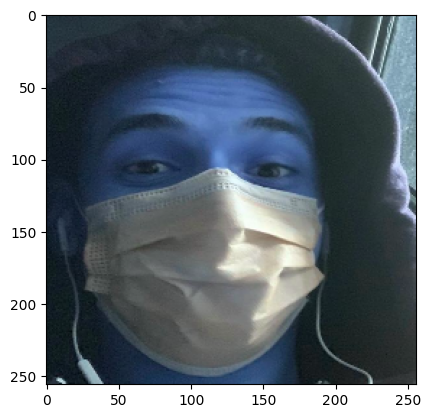

In [ ]:
img_preprocessing('drive/MyDrive/CDSS_DATA/Face Mask Dataset/Validation/WithMask/hassan1.png')

1/1 [==============================] - 0s 21ms/step
             WithoutMask


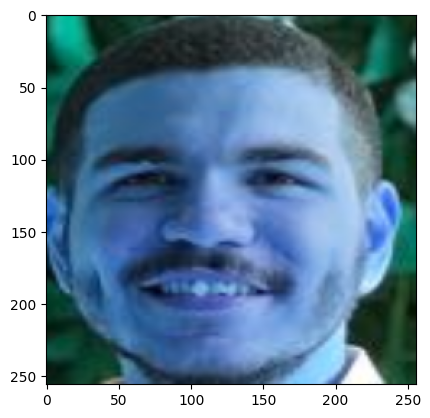

In [ ]:
img_preprocessing('drive/MyDrive/CDSS_DATA/Face Mask Dataset/Validation/WithoutMask/hesham2.png')

1/1 [==============================] - 0s 19ms/step
             WithMask


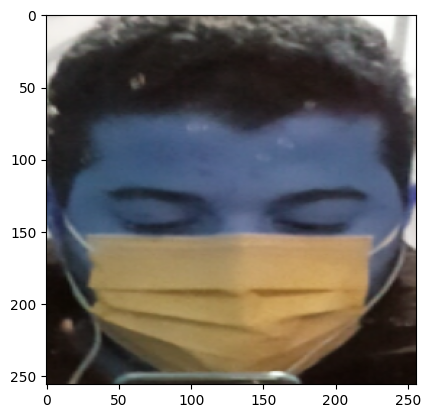

In [ ]:
img_preprocessing('drive/MyDrive/CDSS_DATA/Face Mask Dataset/Validation/WithMask/bedro.png')